# Making a Five Animal Classifier and Deploying It

## Package Installation and Imports

In [ ]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq duckduckgo_search --upgrade

In [ ]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.7.18
Fastcore version: 1.7.29


In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastcore.all import *

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        return L(image_urls)

## Set Notebook Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Colab_Notebooks/pset'

/content/drive/MyDrive/Colab_Notebooks/pset


In [ ]:
%ls

Deep_Learning_pset01


# Gather Data

We are setting our paths to be the simple name of the food (buuz, khuushuur, etc). We will then append "mongolian" to the search term in the loop.

In [ ]:
food_types = 'buuz','huushuur','tsuivan','niislel salad'
path = Path('mongolian_food')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in food_types:
        print(f'Finding images for {o}')
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{o} mongolian food', max_images=50)
        download_images(dest, urls=urls)

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

## Build Data Loader

In [ ]:
foods = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_y=parent_label,
                  item_tfms=RandomResizedCrop(224, min_scale=0.5),
                  batch_tfms=aug_transforms())

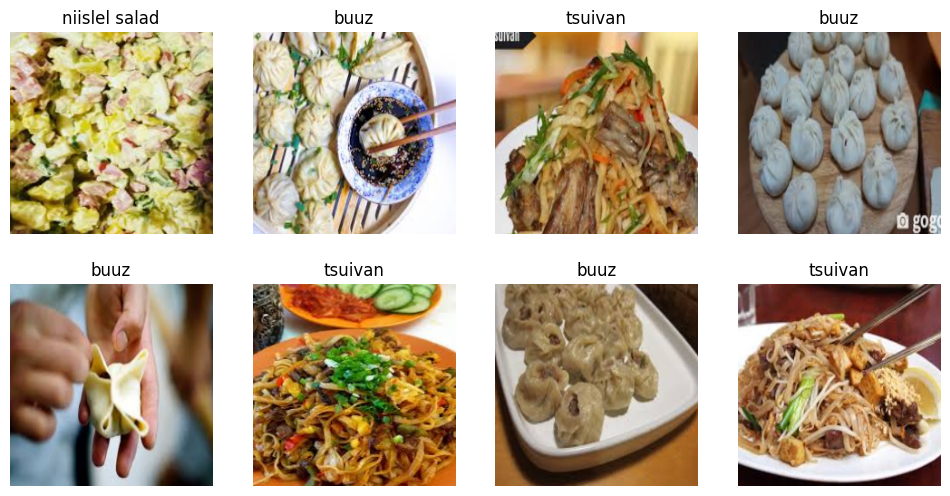

In [ ]:
dls = foods.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

## Perform Transfer Learning

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.747373,3.444912,0.846154,00:19


epoch,train_loss,valid_loss,error_rate,time
0,2.531727,2.673264,0.846154,00:25
1,2.341656,1.724923,0.653846,00:26
2,2.121871,1.056640,0.423077,00:24
3,1.844896,0.667350,0.230769,00:32
4,1.627658,0.480081,0.230769,00:26
5,1.439727,0.414214,0.153846,00:26


## Evaluate Learner

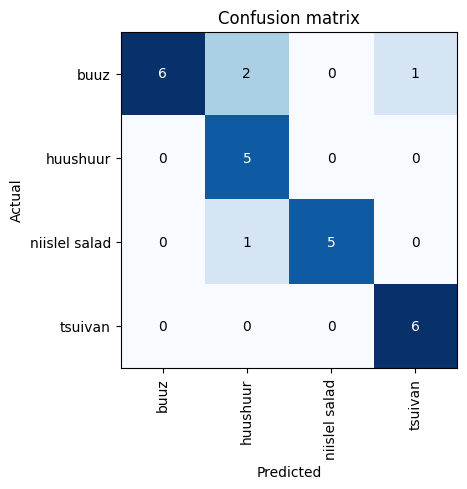

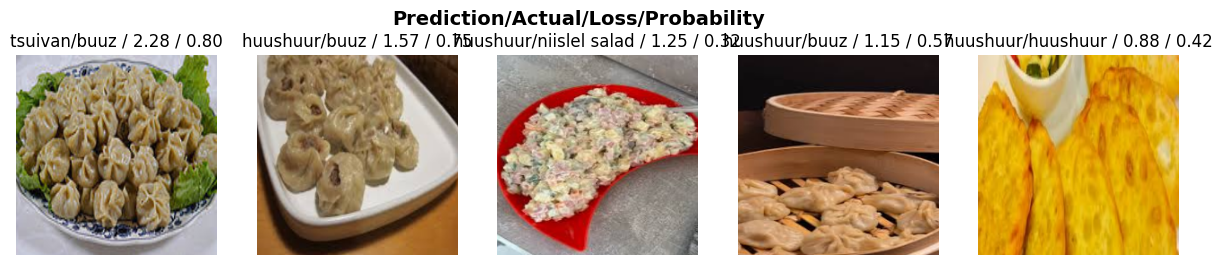

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

## Export Model

In [ ]:
learn.export('mongolian_food_classifier.pkl')